In [1]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
#from numba import njit

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna

using gpu 1


In [3]:
#Input: een keuze tussen bij 4 keuzes (bij 4x?x?)
#Output: Nieuwe environment


class Environment:
    def __init__(self, size, posreward = 2, negreward = -2, maxPriority = 4):
        self.size = size
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        self.posreward = posreward
        self.negreward = negreward
        self.action_space = size[0]
        self.input_space = size[0]*(maxPriority+1)+1
        self.priorityMax = maxPriority
        
    def resetField(self):
        self.environment = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        
    def resetEnvironment(self):
        self.resetField()
        self.score = 0
        self.done = False
    
    def GenerateEnvironment(self):
        return np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        temp = np.array([[[0] * self.size[2]] * self.size[1]] * self.size[0])
        maxcont = self.size[0] * self.size[2]
        for i in range(self.size[1]):
            for o in range(np.random.randint(maxcont*0.65,maxcont)):
                actionPos = self.checkValidPositionInRow(temp,i)
                temp[actionPos] = 1
        return temp
    
    
    #TODO: Voeg een boolean output toe van welke rows al vol zitten en welke niet.
    def genObs(self, env, containerType = 1, flattened = True, normalized = False):
        #Count amount of open containers per row.
        outputlist = np.zeros((self.priorityMax+1,self.size[0]),dtype=np.float32)

        for i in range(self.priorityMax):
            outputlist[i] = (env == i).sum(axis=2).sum(axis=1)
        
        outputlist[-1] = (env != 0).sum(axis=2).sum(axis=1) == np.prod(env.shape[1:3])
        
        if normalized:
            outputlist[:-1] /= np.prod(env.shape[1:3])
        
        
        if flattened:
            return np.concatenate((outputlist.flatten(), np.array([containerType],dtype=np.float32)))
        else:
            return [outputlist,containerType]
    
    def step(self, env, action, priority = 1):
        #actionspace = y
        
        
        #Save Old State
        newState = env.copy()
        actionPos = self.checkValidPositionInRow(env, action)
        
        done = False
        
        #Make move
        if self.placeContainer(actionPos, newState):
            newState[actionPos] = priority
            reward = self.getRewardList(env, priority)[action]
        else:
            reward = np.prod(env.shape[1:3]) * -2
            done = True
            self.done = True

        #End game if field is all filled.
        if np.all(newState != 0):
            done = True
            self.done = True
        return newState, reward, done
    
    def placeContainer(self, pos, env):
        if self.isLegal(pos, env):
            return True
        else:
            return False
        
    def isLegal(self, pos, env):
        IO = self.isOccupied(pos, env)
        IF = self.isFloating(pos, env)
        IIE = self.posIsInEnv(pos, env)
        NAS = self.hasNorthAndSouth(pos, env)
        return not IO and not IF and IIE and not NAS
    
    def isOccupied(self, pos, env):
        if self.posIsInEnv(pos, env):
            return env[pos] != 0
        else:
            return False
    
    def hasNorthAndSouth(self, pos, env):
        NC = self.isOccupied((pos[0],pos[1]-1,0), env)
        SC = self.isOccupied((pos[0],pos[1]+1,0), env)
        return NC and SC
    
    def posIsInEnv(self, pos, env):
        x = 0 <= pos[0] < env.shape[0]
        y = 0 <= pos[1] < env.shape[1]
        z = 0 <= pos[2] < env.shape[2]  
        return x and y and z
    
    def isFloating(self, pos, env):
        return np.any(env[pos[0],pos[1],:pos[2]] == 0)
    
    def checkValidPositionInRow(self, env, row):
        positions = np.dstack(np.where(env[row,:,:] == 0))
        if positions.size != 0:
            result = positions[positions[:,:,0] == np.max(positions[:,:,0])][0]
            
        else:
            result = (0,0)
        return row, result[0], result[1]
    
    def getRewardList(self,env,containerPriority):
        obs = self.genObs(env,containerPriority,flattened=False)
        #
        emptyRows = obs[0][0] == np.prod(env.shape[1:3])
        amtRows = obs[0][1:-1].sum(axis=0)
        prioRows = obs[0][1:-1]
        fullRows = obs[0][-1]
        containerRow = prioRows[containerPriority-1]
        ratioRow = containerRow/amtRows
        ratioRow[ratioRow == np.inf] = 0
        ratioRow[np.isnan(ratioRow)] = 0
        #print(fullRows)
        result = ratioRow+emptyRows/2
        #result[fullRows] = 0
        result *= fullRows*-1 + 1
        #print(result)
        
        #result = obs[0][1:-1].sum(axis=0) * (obs[0][-1]+1) - np.prod(env.shape[1:3]) * (obs[0][-1]*-1) + emptyRows
        
        return result

In [100]:
#Reward: When putting same type containers 

env = Environment(size=(5,5,5))

testenv = np.empty((5,5,5))
testenv[0,:,:] = 1
#testenv[0,:,:] = 0
#testenv[0,1,0] = 1
#testenv[0,2,0] = 1
testenv[1,2:,:] = 1
testenv[1,0,:] = 3
#testenv[1,1:,:] = 2
#print(testenv)
containerpriority = 1
action = 1
#print(testenv)
#env.genObs(testenv,10,normalized=True)
env.getRewardList(testenv,containerpriority)


[1. 0. 0. 0. 0.]
[0.   0.75 0.5  0.5  0.5 ]


/tmp/ipykernel_23282/3364263665.py:128: RuntimeWarning: invalid value encountered in true_divide
  ratioRow = containerRow/amtRows


array([0.  , 0.75, 0.5 , 0.5 , 0.5 ])

In [96]:
#UnitTests
for o in range(2):
    e = Environment(size=(3,3,2))
    environment = e.GenerateEnvironment()
    environment[1,:,:] = 3
    environment[1,1,:] = 1
    
    print(e.genObs(environment),e.input_space)
    

[6. 0. 6. 0. 2. 0. 0. 0. 0. 0. 4. 0. 0. 1. 0. 1.] 16
[6. 0. 6. 0. 2. 0. 0. 0. 0. 0. 4. 0. 0. 1. 0. 1.] 16


In [22]:
#UnitTests

Steps = [[2,2,1,0,0,2,0,0,0,1]]

for o in Steps:
    e = Environment(size=(3,3,3))
    environment = e.GenerateEnvironment()
    
    for i in o:
        environment, reward, done = e.step(environment,i)
        print("Action: ",i, "\nEnvironment: \n", environment, "\nReward", reward)
        print(done)
    print("Test ",o," done\n",e.genObs(environment))
    print(e.input_space)


(2, 2, 0)
Action:  2 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]] 
Reward 2
False
(2, 2, 1)
Action:  2 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 0]]] 
Reward 2
False
(1, 2, 0)
Action:  1 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 0]]] 
Reward 2
False
(0, 2, 0)
Action:  0 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 0]]] 
Reward 2
False
(0, 2, 1)
Action:  0 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [1 1 0]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 0]]] 
Reward 2
False
(2, 2, 2)
Action:  2 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [1 1 0]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 1]]] 
Reward 2
False
(0, 2, 2)
Action:  0 
Environment: 
 [[[0 0 0]
  [0 0 0]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [1 0 0]]

 [[0 

# Model

Agent(
    -Environment
    -CNN
    -Trainer)
    
    
    
# Pseudo pseudocode
<code>N = 10</code>

<code>While True:</code><br>
<code>    //Gaming moment (play 10 games)</code><br>
<code>    for i in range(10):</code><br>
<code>        pred = agent.pred()</code><br>
<code>        agent.rememberMoves()</code><br>
<code>    //Learning moment (train on previous games if possible)</code><br>
<code>    agent.trainNN()</code><br>

TODO: INCLUDE SCORING



# Convolutional Neural Network

In [4]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=64, fc2_dims=64):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.sigmoid = nn.Sigmoid()
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions

In [5]:
class Agent():
    def __init__(self, gamma, lr, batch_size, max_mem_size=100000, size = (3,3,2),epsilon = 0.99, eps_end=0.01, eps_dec=5e-3):
        
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        
        
        self.lr = lr
        self.gamma = gamma
        
        #Create Environment
        self.env = Environment(size)
        
        #self.action_space = self.env.action_space
        self.action_space = [i for i in range(self.env.action_space)]
        
        #Create Convolutional Neural Network
        self.Q_eval = DeepQNetwork(lr = lr, input_dims = self.env.input_space, n_actions = self.env.action_space)
        
        #Memory variables
        self.mem_size = max_mem_size
        self.mem_cntr = 0
        self.batch_size = batch_size
        
        #Memory array variables
        self.state_memory = np.zeros((self.mem_size, self.env.input_space), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, self.env.input_space), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        
    def chooseAction(self, observation):
        if np.random.random() > self.epsilon:
            #Turn observation into tensor
            state = T.tensor([observation]).to(self.Q_eval.device)
            #Get action from neural network
            actions = self.Q_eval.forward(state)

            #Get maximum value and return index
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
        
    def rememberMoves(self, state, action, reward, state_, done):
        #Makes counter loop over if max has been reached.
        index = self.mem_cntr % self.mem_size
        
        #Save specific variables to arrays
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        #Increment memory counter
        self.mem_cntr += 1
        
    #TODO: We still need to add the trainer to this part.
    def trainNN(self):
        #If there's not enough memory for the batch size. Don't learn.
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        #Check what the maximum size is of the memory
        max_mem = min(self.mem_cntr, self.mem_size)
        
        #Choose a random batch
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        #Get batch indices for the batch size. (aka an array of batch_size int32s)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        #Load batch memory to device in tensors.
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
    
        
        #Load action batch memory.
        action_batch = self.action_memory[batch]
        
        #Generate output for eval state.
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        
        #Generate output for next state.
        q_next = self.Q_eval.forward(new_state_batch)
        
        #Done state gets reset for the terminal batch?? idk?
        q_next[terminal_batch] = 0.0
        
        #Apply rewards to next batch.
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
    
    

In [79]:
a = Agent(0.95, 0.01, 256, size=(4, 4, 5), eps_dec=5e-3,eps_end=0.001)

RewardHistory = []
RewardHistoryHistory = []

done = False
n_games = 100000
N = 10

successful_games = 0

lastObservation = 0

startTime = datetime.now()

for o in range(n_games):
    
    nhistory = []
    for i in range(N):
        a.env.resetEnvironment()
        env = a.env.GenerateEnvironment()
        priorityList = np.random.randint(1,a.env.priorityMax,size=(np.prod(env.size)))
        #priorityList = np.full((np.prod(env.size)),1)
        done = False
        episodescore = []
        boardObservations = []
        while not a.env.done:
            
            
            obs = a.env.genObs(env,priorityList[-1],normalized=True)
            
            action = a.chooseAction(obs)
            
            newenv, reward, done = a.env.step(env,action,priority=priorityList[-1])
            
            
            
            a.rememberMoves(obs, action, reward, a.env.genObs(newenv,priorityList[-1]), done)
            
            priorityList = priorityList[:-1]
            
            env = newenv
            boardObservations.append(env)
            
            episodescore.append(reward)
            
            if np.all(env != 0):
                successful_games += 1
        
        if(o%100 == 0 and i == 0):
            np.save('Observations/array%i.npy'%(o),boardObservations)
        
        nhistory.append(np.sum(episodescore))
    a.trainNN()
    RewardHistory.append(np.mean(nhistory))
    
    
    clear_output(wait=True)
    print("Episode %i/%i score %.2f epsilon %.2f\nThe last %i games had %i successful games"%(o*N,n_games,RewardHistory[-1],a.epsilon,o*N,successful_games),flush=True)
    
    #print(RewardHistory)

Episode 79270/100000 score 67.57 epsilon 0.00
The last 79270 games had 75663 successful games


KeyboardInterrupt: 

In [80]:
endTime = datetime.now()

396 396


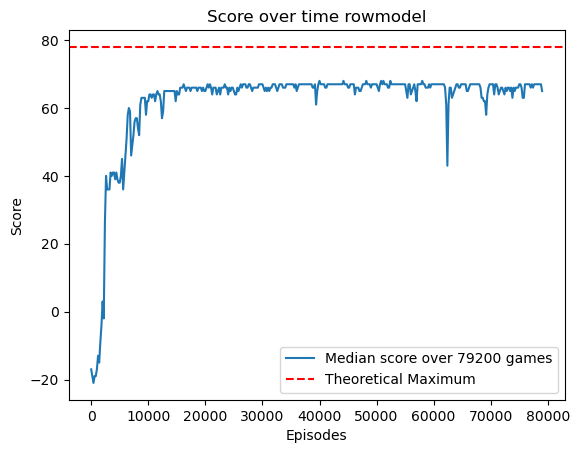

In [87]:
from datetime import datetime
smoothingFactor = 20
dataLENGTH = int(len(RewardHistory)/smoothingFactor)*smoothingFactor
#print(dataLENGTH)
dataREFORMATTED = np.median(np.reshape(RewardHistory[0:dataLENGTH],(-1,smoothingFactor)),axis=1)

xAxisList = np.arange(0,len(dataREFORMATTED)*smoothingFactor*10,smoothingFactor*10)
ProjectedData = np.array((dataREFORMATTED,),dtype=int).T
print(len(xAxisList),len(ProjectedData))

plt.plot(xAxisList,ProjectedData,label="Median score over "+ str(dataLENGTH*10) + " games")
plt.axhline(y = np.prod(a.env.size) - a.env.size[0] + 0.5 * a.env.size[0], color = 'r', linestyle = '--',label="Theoretical Maximum")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Score over time rowmodel")
plt.savefig('graphs/%s.png'%(datetime.now().strftime("%d-%m-%Y %H-%M-%S")), dpi=300)

plt.show()

In [86]:
(endTime - startTime)

datetime.timedelta(seconds=4847, microseconds=730715)

In [ ]:
sda;klfljk

In [ ]:
len(priorityList[:-1])

In [ ]:
optuna.visualisation.plot_slice(study)

In [ ]:
def trial(trial):
    lr = trial.suggest_float('lr', 1e-1, 1e-4, log=True)
    
    # process of training model
    model = CNN(lr = lr, )
    t = Trainer()
    t.train
    
    return #score

study = optuna.create_study(direction = 'maximize')
study.optimize(trial, n_trials= 100, show_progress_bar=True)

In [ ]:
a.Q_eval